In [1]:
import torch, torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet input size
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [4]:

data = datasets.ImageFolder(r"C:\Users\amipa\Downloads\sipakmedwsi", transform=transform)
train_size = int(0.8 * len(data))
train_data, val_data = random_split(data, [train_size, len(data) - train_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

In [5]:

model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)  # Herlev has 7 classes
model = model.to(device)

C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:

for epoch in range(10):  # Can increase if needed
    model.train()
    running_loss = 0.0  # Initialize running loss for the epoch
    for i, (x, y) in enumerate(train_loader): # Added enumerate for batch count
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Add current batch loss

    # Print the average loss for the epoch
    epoch_loss = running_loss / len(train_loader) # Calculate average loss
    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 1.6850
Epoch [2/10], Loss: 1.0210
Epoch [3/10], Loss: 0.6036
Epoch [4/10], Loss: 0.3728
Epoch [5/10], Loss: 0.2105
Epoch [6/10], Loss: 0.1849
Epoch [7/10], Loss: 0.1032
Epoch [8/10], Loss: 0.0632
Epoch [9/10], Loss: 0.0538
Epoch [10/10], Loss: 0.1080


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.eval()
correct, total, preds, labels = 0, 0, [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(1)
        preds.extend(pred.cpu().numpy())
        labels.extend(y.cpu().numpy())
        correct += (pred == y).sum().item()
        total += y.size(0)

accuracy = accuracy_score(labels, preds) * 100
f1 = f1_score(labels, preds, average='macro')
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')

# Print results
print(f"Accuracy:  {accuracy:.2f}%")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Accuracy:  93.30%
F1 Score:  0.9354
Precision: 0.9326
Recall:    0.9406


In [12]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np

# K-Fold setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []
fold_logs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(kfold.split(data)):
    print(f"\n--- Fold {fold+1} ---")

    train_sub = Subset(data, train_idx)
    val_sub = Subset(data, val_idx)
    train_dl = DataLoader(train_sub, batch_size=32, shuffle=True)
    val_dl = DataLoader(val_sub, batch_size=32)

    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)  
   
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    log = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(5):  # You can increase this
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        train_acc = correct / total
        train_loss = running_loss / len(train_dl)
        log['train_acc'].append(train_acc)
        log['train_loss'].append(train_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        preds, labels = [], []
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                pred = out.argmax(1)
                preds.extend(pred.cpu().numpy())
                labels.extend(y.cpu().numpy())
                correct += (pred == y).sum().item()
                total += y.size(0)
                running_loss += loss.item()
        val_acc = correct / total
        val_loss = running_loss / len(val_dl)
        log['val_acc'].append(val_acc)
        log['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")

    fold_accuracies.append(val_acc)
    fold_f1s.append(f1_score(labels, preds, average='macro'))
    fold_logs.append(log)

# Final metrics
print(f"\nAvg Accuracy: {np.mean(fold_accuracies)*100:.2f}%")
print(f"Avg F1 Score: {np.mean(fold_f1s):.4f}")



--- Fold 1 ---
Epoch 1: Val Acc = 0.7062, Val Loss = 1.4143
Epoch 2: Val Acc = 0.8144, Val Loss = 0.8943
Epoch 3: Val Acc = 0.8608, Val Loss = 0.5687
Epoch 4: Val Acc = 0.8918, Val Loss = 0.3653
Epoch 5: Val Acc = 0.8814, Val Loss = 0.3298

--- Fold 2 ---


C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Acc = 0.6684, Val Loss = 1.2924
Epoch 2: Val Acc = 0.8187, Val Loss = 0.8120
Epoch 3: Val Acc = 0.8497, Val Loss = 0.5268
Epoch 4: Val Acc = 0.8860, Val Loss = 0.3809
Epoch 5: Val Acc = 0.8860, Val Loss = 0.3448

--- Fold 3 ---


C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Acc = 0.7772, Val Loss = 1.2715
Epoch 2: Val Acc = 0.7979, Val Loss = 0.7249
Epoch 3: Val Acc = 0.8394, Val Loss = 0.4663
Epoch 4: Val Acc = 0.8549, Val Loss = 0.3395
Epoch 5: Val Acc = 0.8756, Val Loss = 0.2865

--- Fold 4 ---


C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Acc = 0.6995, Val Loss = 1.3853
Epoch 2: Val Acc = 0.8187, Val Loss = 0.8354
Epoch 3: Val Acc = 0.9067, Val Loss = 0.4603
Epoch 4: Val Acc = 0.9378, Val Loss = 0.3093
Epoch 5: Val Acc = 0.9430, Val Loss = 0.2244

--- Fold 5 ---


C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\amipa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Val Acc = 0.7098, Val Loss = 1.3349
Epoch 2: Val Acc = 0.8083, Val Loss = 0.8382
Epoch 3: Val Acc = 0.8497, Val Loss = 0.5109
Epoch 4: Val Acc = 0.8808, Val Loss = 0.3424
Epoch 5: Val Acc = 0.9016, Val Loss = 0.2861

Avg Accuracy: 89.75%
Avg F1 Score: 0.9079


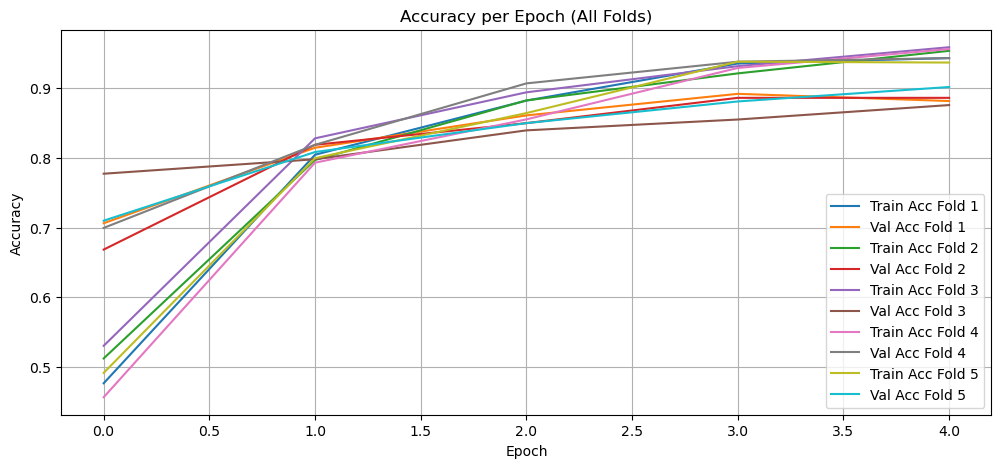

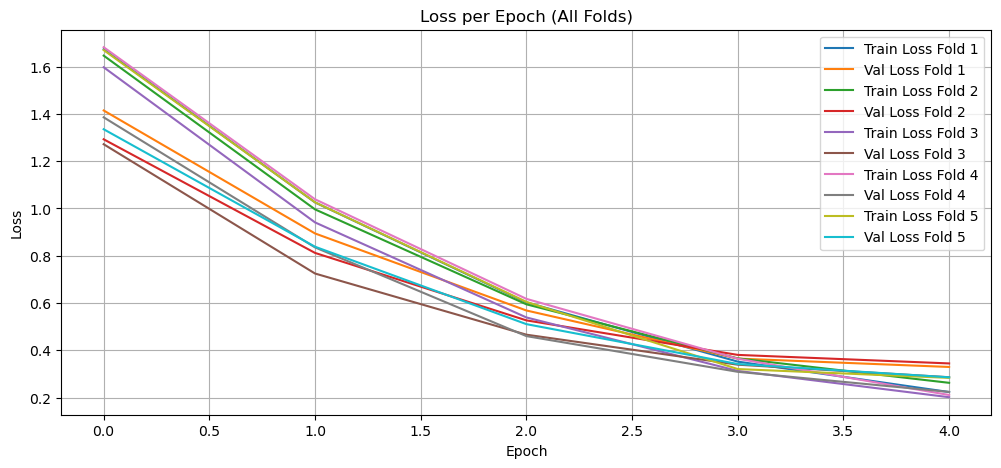

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for i, log in enumerate(fold_logs):
    plt.plot(log['train_acc'], label=f'Train Acc Fold {i+1}')
    plt.plot(log['val_acc'], label=f'Val Acc Fold {i+1}')
plt.title("Accuracy per Epoch (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(12, 5))
for i, log in enumerate(fold_logs):
    plt.plot(log['train_loss'], label=f'Train Loss Fold {i+1}')
    plt.plot(log['val_loss'], label=f'Val Loss Fold {i+1}')
plt.title("Loss per Epoch (All Folds)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()